## Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.utils import save_image
from tqdm import tqdm
import torchvision.datasets as datasets  
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'
print(f'Device: {device}')

d:\Programs\Anaconda\Anaconda\envs\AI_generic\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device: cuda


## Define the image transformation pipeline and load data

In [2]:
transform = transforms.Compose([
                                transforms.ToTensor(), 
                                # transforms.Normalize(mean=[0.5], std=[0.5])
                                ])

train_data = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

## Define the Model

In [3]:
class VariationalAutoEncoder(nn.Module):
    def __init__(self, 
                latent_dim = 20, # Dimensionality of latent space
                ):
        super().__init__()

        # Encoder
        self.conv1 = nn.Conv2d(1, 32, (3,3), padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(7*7*64, 512)  # Flatten the output of conv2 and pool2
        
        # Latent space representation
        self.fc_mu = nn.Linear(512, latent_dim)  # Mean (mu)
        self.fc_logvar = nn.Linear(512, latent_dim)  # Log variance (log(σ^2))

       
        # Decoder
        self.fc2 = nn.Linear(latent_dim, 512)
        self.fc3 = nn.Linear(512, 7*7*64)
        
        self.deconv1 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)  # (14, 14, 32)
        self.deconv2 = nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1)  # (28, 28, 1)


    def encode(self, x):
        # x: (1, 28, 28)

        # Apply convolutional layers followed by max pooling
        x = torch.relu(self.conv1(x)) # x: (N, 32, 28, 28)
        x = self.pool1(x) # x: (N, 32, 14, 14)
        x = torch.relu(self.conv2(x)) # x: (N, 64, 14, 14)
        x = self.pool2(x) # x: (N, 64, 7, 7)
        
        # Flatten the tensor
        x = x.view(x.size(0), -1)  # Flatten to (N, 7*7*64)
        
        # Fully connected layer
        x = torch.relu(self.fc1(x)) # x: (N, 512)
        
        # Output latent variables (mean and log variance)
        mu = self.fc_mu(x) # mu: (N, 20)
        logvar = self.fc_logvar(x) # logvar: (N, 20)

        return mu, logvar
    
    def decode(self, x):
        # x: (N, 20)
        # Fully Connected Layers
        x = torch.relu(self.fc2(x)) # x: (N, 512)
        x = torch.relu(self.fc3(x)) # x: (N, 64*7*7)

        # UnFlatten
        x = x.view(x.size(0), 64, 7, 7) # x: (N, 64, 7, 7)
        
        # Deconv
        x = torch.relu(self.deconv1(x)) # x: (N, 64, 14, 14)
        x = torch.sigmoid(self.deconv2(x)) # x: (N, 32, 28, 28)
        return x

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std


    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_reconstructed = self.decode(z)
        return x_reconstructed, mu, logvar

## Define Loss Function

### The loss function of VAE is given by:
$$ L_{VAE} = L_{recon} + L_{KL} $$
$$ L_{recon} = - \mathbb{E}_{q(z|x)}[\log{p(x|z)}] = -\frac{1}{N} \sum_{i=1}^{N}\log{p(x_i|z_i)}$$
$$\textrm{and} $$
$$ L_{KL} = D_{KL}(q(z|x) || p(z))  = \frac{1}{2} \sum_{j=1}^{d}(\mu^2_j+\sigma^2_j-\log{(\sigma^2_j)-1})$$

In [4]:
def vae_loss(x_reconstructed, x, mu, logvar):
    BCE_loss = nn.BCELoss(reduction='sum')(x_reconstructed.view(-1, 28 * 28), x.view(-1, 28 * 28))
    assert(BCE_loss >= 0)
    # KL Divergence
    # D_KL(q(z|x) || p(z)) = -0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)

    KL_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    assert(KL_divergence >= 0)
    
    return BCE_loss + KL_divergence

## Define train function

In [5]:
def train(num_epochs, model, optimizer, loss_fn):
    # Start training
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        with tqdm(total=len(train_loader.dataset), desc=f'Epoch {epoch+1}/{num_epochs}', unit='img') as pbar:
            for data, _ in train_loader:
                # data: (N, 1, 28, 28)
                x = data.to(device)
                # print(f'x: {x.min(), x.max()}')
                optimizer.zero_grad()
        
                # Forward pass
                x_reconstructed, mu, logvar = model(x)
                # print(f'x_rec: {x_reconstructed.min(), x_reconstructed.max()}')
        
                # x_reconstructed: (N, 1, 28, 28)
                # mu: (N, 1, 20)
                # logvar: (N, 1, 20)

                loss = loss_fn(x_reconstructed, x, mu, logvar)

                loss.backward()
                optimizer.step()
                train_loss += loss.item()

                # Update progress bar
                pbar.set_postfix({'Loss': loss.item()})
                pbar.update(data.size(0))  # Update with batch size
        avg_train_loss = train_loss / len(train_loader.dataset)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}')
        
        # Optionally, evaluate on the test set with tqdm
        model.eval()
        with torch.no_grad():
            test_loss = 0.0
            with tqdm(total=len(test_loader.dataset), desc='Evaluating', unit='img') as pbar:
                for data, _ in test_loader:
                    data = data.to(device)
                    recon_data, mu, logvar = model(data)
                    loss = loss_fn(recon_data, data, mu, logvar)
                    test_loss += loss.item()
                    pbar.update(data.size(0))  # Update with batch size

            avg_test_loss = test_loss / len(test_loader.dataset)
            print(f'Test Loss: {avg_test_loss:.4f}')

In [8]:
# Initialize model, optimizer, loss
NUM_EPOCHS = 3
LATENT_DIM = 20
BATCH_SIZE = 32
LR = 1e-3
model = VariationalAutoEncoder(LATENT_DIM).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
loss_fn = nn.BCELoss(reduction="sum")

# Run training
train(NUM_EPOCHS, model, optimizer, vae_loss)

Epoch 1/3: 100%|██████████| 60000/60000 [00:18<00:00, 3158.02img/s, Loss=3.74e+3]


Epoch [1/3], Loss: 139.5037


Evaluating: 100%|██████████| 10000/10000 [00:01<00:00, 6449.49img/s]


Test Loss: 111.2253


Epoch 2/3: 100%|██████████| 60000/60000 [00:18<00:00, 3309.69img/s, Loss=3.52e+3]


Epoch [2/3], Loss: 108.0057


Evaluating: 100%|██████████| 10000/10000 [00:01<00:00, 6324.41img/s]


Test Loss: 105.0789


Epoch 3/3: 100%|██████████| 60000/60000 [00:18<00:00, 3227.97img/s, Loss=3.4e+3] 


Epoch [3/3], Loss: 104.0883


Evaluating: 100%|██████████| 10000/10000 [00:01<00:00, 6334.31img/s]

Test Loss: 102.7508


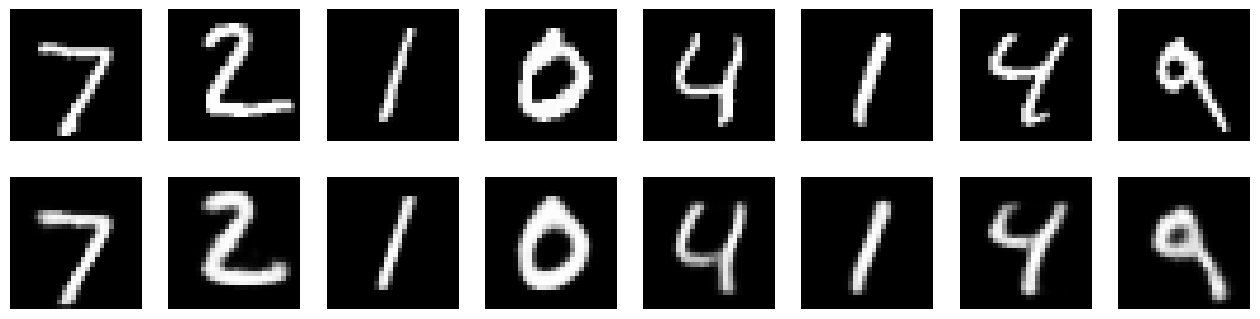

In [10]:
def infer(vae, data_loader, device='cpu'):
    vae.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        # Get one batch of data from the data loader (for visualization)
        data, _ = next(iter(data_loader))  # Get the first batch
        data = data.to(device)

        # Pass data through the encoder and decoder
        mu, logvar = vae.encode(data)
        z = vae.reparameterize(mu, logvar)
        recon_data = vae.decode(z)

        # Convert tensor to numpy for visualization
        data = data.cpu().numpy()
        recon_data = recon_data.cpu().numpy()

        # Plot the original and reconstructed images side by side
        _, axes = plt.subplots(2, 8, figsize=(16, 4))
        for i in range(8):
            # Original Image
            axes[0, i].imshow(data[i][0], cmap='gray')
            axes[0, i].axis('off')
            # Reconstructed Image
            axes[1, i].imshow(recon_data[i][0], cmap='gray')
            axes[1, i].axis('off')

        plt.show()

# Example of calling the inference function
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Call the inference function to display original and reconstructed images
infer(model, test_loader, device)